<a href="https://colab.research.google.com/github/ariana-caetano/python_mercado-financeiro/blob/main/Previsao_com_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Previsão de preços de ações usando LSTM**




Comecei a estudar sobre machine learning, em um curso que estou fazendo (ou estava em junho de 2022, não sei quando você está lendo esse texto), e achei o tema muito interessante.

E então veio a ideia, é possível fazer previsão do preço de uma ação? Será que os os engenheiros de machine learning são milionários e estão escondendo esse segredo da gente? 

Chegou a minha vez de ficar rica?

<center><img src="https://media.giphy.com/media/HChtj3gzcVsXK/giphy.gif" align="middle"></center>

Bom, acredito que não é bem assim!! É só pensar na previsão do tempo, nem sempre ela acerta!

Quando o assunto é mercado financeiro, a complexidade é grande e existem muitas variáveis que podem afetar o preço: saúde da empresa, notícias, questões políticas, taxa de juros, inflação, etc e etc.

Por isso, não vá usar esse estudo como uma forma de investir, só achei que poderia ser divertido fazer essa previsão e descobrir como seria o resultado.
Vou deixar uma frase que ouvi e é muito importante para refletirmos, procurei sobre a autoria da frase e encontrei ligações ao Niels Bohr (um físico dinamarquês), a Yogi Berra (um técnico de basebol americano), mas não encontrei ao certo a quem pertence: 

**“Fazer previsões é difícil, especialmente sobre o futuro”**



## **LSTM - Long Short Term Memory**

Vou deixar [aqui](https://https://www.deeplearningbook.com.br/arquitetura-de-redes-neurais-long-short-term-memory/) a fonte do texto que usei para definir o que é LSTM.

"Os humanos não começam a pensar do zero a cada segundo. Ao ler este capítulo, você entende cada palavra com base em sua compreensão das palavras anteriores. Você não joga tudo fora e começa a pensar de novo a cada palavra que você lê. Seus pensamentos têm persistência.

A LSTM é uma arquitetura de rede neural recorrente (RNN) que “lembra” valores em intervalos arbitrários. A LSTM é bem adequada para classificar, processar e prever séries temporais com intervalos de tempo de duração desconhecida."

Essa foi uma definição simples, que nos faz entender um pouco como a LSTM funciona, mas há muito mais detalhes a serem compreendidos, mas não serão abordados aqui.

Gosto muito de aprender utilizando exemplos, e nesse estudo vou replicar um que vi no [Youtube](https://www.youtube.com/watch?v=CvfAx3_nGME&t=2127s).

Então vamos às nossas previsões!!!

<center><img src="https://media.giphy.com/media/r7HB3m9JvObe7rT0xZ/giphy.gif" align="middle"></center>


In [ ]:
#instalação da biblioteca yfinance que usaremos para pegar as cotações das ações
!pip install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 1.2 MB/s 
     |████████████████████████████████| 6.4 MB 48.0 MB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.28.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
#importando as bibliotecas

import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
import matplotlib.pyplot as plt


In [ ]:
#Resolvi usar o código da ELET3, pois ela está na mídias nos últimos dias
# devido às notícias de privatização

codigoAcao = 'ELET3.SA'
#Não coloquei data pois queria pegar todo o período de dados
dataInicial = "2008-01-02"
dataFinal = "2022-06-04"
#dados_ativo = yf.download(codigoAcao)
#exemplo passando datas
dados_ativo = yf.download(codigoAcao, start = dataInicial, end = dataFinal)

[*********************100%***********************]  1 of 1 completed


Text(0.5, 0, 'Date')

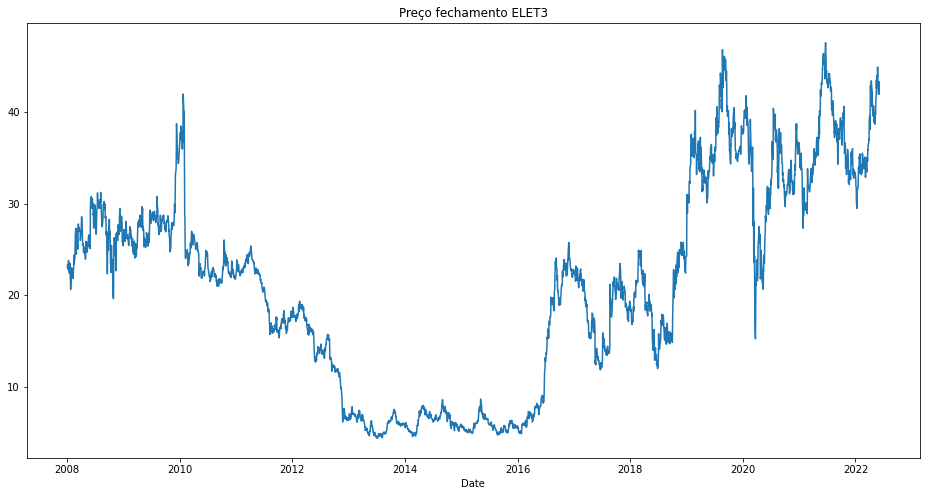

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Preço fechamento ELET3')
plt.plot(dados_ativo['Close'])
plt.xlabel('Date')

In [ ]:
#vamos utilizar apenas os dados da coluna Close
dados_Close = dados_ativo[['Close']]
#verificar a quantidade de linhas
qtde_linhas = len(dados_Close)

#separar uma parte para teste e outra para treino no nosso modelo
qtde_linhas_treino = round(qtde_linhas*0.7)
qtde_linhas_teste = qtde_linhas - qtde_linhas_treino

In [ ]:
#normalizando os dados
#para que a rede entenda que os valores tem o mesmo peso
scaler = StandardScaler()
dados_normalizados = scaler.fit_transform(dados_Close)

# Separando o conjunto de dados em treino e teste
train = dados_normalizados[:qtde_linhas_treino]
test = dados_normalizados[qtde_linhas_treino:qtde_linhas_treino+qtde_linhas_teste]

#existe o train_test_split, mas aqui não foi utilizado pois é nescessário manter a ordem dos dados
#porque aqui temos uma série temporal

In [ ]:
#vamos utilizar o modelo LSTM e aqui vamos criar uma função que cria o dataframe no formato que é esperado pelo modelo
def criar_dataFrame(df, steps=1):
  dataX, dataY  = [],[] 
  for i in range(len(df)-steps-1):
    a = df[i:(i+steps),0]
    dataX.append(a)
    dataY.append(df[i + steps,0])
  return np.array(dataX), np.array(dataY)


In [ ]:
#gerando os dados de treino e teste

#steps são a quantidade de dias que vamos olhar para trás
steps = 15
X_train, y_train = criar_dataFrame(train,steps)
X_test, y_test = criar_dataFrame(test,steps)

#1 é a quantidade de colunas que está recebendo que é só o Close
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1],1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1],1)

In [ ]:
#criando o modelo de machine learning
modelo = Sequential()

#adicionando a camada com 35 neurônios
#return_sequences = True significa que o valor de saída vai entrar novamente no bloco da rede neural
modelo.add(LSTM(35,return_sequences=True,input_shape=(steps,1)))
modelo.add(LSTM(35,return_sequences=True))
modelo.add(LSTM(35))
#dropout é usado para não causar overfitting
modelo.add(Dropout(0.2))
#saída de 1 neurônio que é o que a gente quer prever
modelo.add(Dense(1))


modelo.compile(optimizer='adam', loss='mse')
modelo.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 15, 35)            5180      
                                                                 
 lstm_1 (LSTM)               (None, 15, 35)            9940      
                                                                 
 lstm_2 (LSTM)               (None, 35)                9940      
                                                                 
 dropout (Dropout)           (None, 35)                0         
                                                                 
 dense (Dense)               (None, 1)                 36        
                                                                 
Total params: 25,096
Trainable params: 25,096
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#treinando o modelo (demorou cerca de 7 minutos para executar comigo)
validacao = modelo.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=15, verbose=2)

Epoch 1/100
166/166 - 13s - loss: 0.0523 - val_loss: 0.1234 - 13s/epoch - 80ms/step
Epoch 2/100
166/166 - 6s - loss: 0.0238 - val_loss: 0.0630 - 6s/epoch - 36ms/step
Epoch 3/100
166/166 - 5s - loss: 0.0213 - val_loss: 0.0950 - 5s/epoch - 32ms/step
Epoch 4/100
166/166 - 6s - loss: 0.0199 - val_loss: 0.0387 - 6s/epoch - 37ms/step
Epoch 5/100
166/166 - 3s - loss: 0.0194 - val_loss: 0.0282 - 3s/epoch - 21ms/step
Epoch 6/100
166/166 - 3s - loss: 0.0169 - val_loss: 0.0412 - 3s/epoch - 18ms/step
Epoch 7/100
166/166 - 3s - loss: 0.0162 - val_loss: 0.0287 - 3s/epoch - 18ms/step
Epoch 8/100
166/166 - 3s - loss: 0.0154 - val_loss: 0.0558 - 3s/epoch - 18ms/step
Epoch 9/100
166/166 - 3s - loss: 0.0131 - val_loss: 0.0183 - 3s/epoch - 18ms/step
Epoch 10/100
166/166 - 3s - loss: 0.0135 - val_loss: 0.0239 - 3s/epoch - 18ms/step
Epoch 11/100
166/166 - 3s - loss: 0.0126 - val_loss: 0.0358 - 3s/epoch - 18ms/step
Epoch 12/100
166/166 - 3s - loss: 0.0107 - val_loss: 0.0151 - 3s/epoch - 17ms/step
Epoch 13/10

O gráfico abaixo mostra um histórico do treinamento do modelo, comparando o MSE (Mean Square Error) entre a base de treino e validação (teste) ao longo das épocas.
É possível perceber que o MSE começa alto e diminui muito rapidamente no início, e após algumas épocas a queda vai diminuindo lentamente.

**Nota:** Os resultados podem ser diferentes a cada execução, por isso, se você estiver rodando o código agora, seu gráfico provavelmente estará diferente do exibido abaixo. Mais informações sobre o porquê os modelos de machine learning têm resultados diferentes a cada execução clique [aqui](https://machinelearningmastery.com/different-results-each-time-in-machine-learning/)

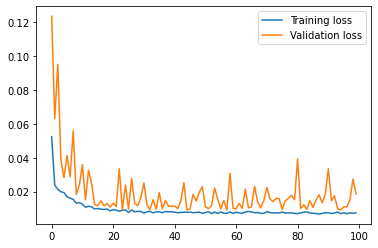

In [ ]:
#mostra o gráfico do comportamento 
plt.plot(validacao.history['loss'], label='Training loss')
plt.plot(validacao.history['val_loss'], label='Validation loss')
plt.legend()


In [ ]:
previsao = modelo.predict(X_test)
previsao = scaler.inverse_transform(previsao)


In [ ]:
#previsão para os próximos 10 dias

#verificar o tamanho do teste
tamanho_teste = len(test)

#pegar os últimos dias 15 dias (steps) da base de teste
qtde_dias_ate_steps = tamanho_teste - steps

#15 dias para trás que usaremos para prever
dias_steps = test[qtde_dias_ate_steps:]
dias_steps = np.array(dias_steps).reshape(1,-1)

#tranformando em uma lista
lista_dias_steps = list(dias_steps)
lista_dias_steps = lista_dias_steps[0].tolist()

In [ ]:
#agora vamos fazer um loop para fazer a previsão
previsao_dez = []
i=0
n_dias_previsao = 10
while(i<n_dias_previsao):
  if(len(lista_dias_steps) > steps):
    dias_steps = np.array(lista_dias_steps[1:])
    dias_steps = dias_steps.reshape(1,-1)
    dias_steps = dias_steps.reshape((1, steps,1))
    previsao = modelo.predict(dias_steps, verbose=0)
    lista_dias_steps.extend(previsao[0].tolist())
    lista_dias_steps = lista_dias_steps[1:]
    previsao_dez.extend(previsao.tolist())
    i=i+1
  else:
    dias_steps = dias_steps.reshape((1, steps,1))
    previsao = modelo.predict(dias_steps, verbose=0)
    lista_dias_steps.extend(previsao[0].tolist())
    previsao_dez.extend(previsao.tolist())
    i=i+1

In [ ]:
previsao = scaler.inverse_transform(previsao_dez)
previsao = np.array(previsao).reshape(1,-1)
lista_previsao = list(previsao)
lista_previsao = previsao[0].tolist()

In [ ]:
#criar um dataframe com as datas e as previsões de preço
datas = dados_Close.index.tolist()
previsao_datas = pd.date_range(list(datas)[-1] + pd.DateOffset(1), periods=10, freq='b').tolist()

dt = []
for i in previsao_datas:
  dt.append(i.date())

df_previsao = pd.DataFrame({'Data': np.array(dt), 'Fechamento': lista_previsao})

# df_previsao['Data'] = pd.to_datetime(df_previsao['Data'].values)
df_previsao = df_previsao.set_index(pd.DatetimeIndex(df_previsao['Data'].values))
# df_previsao = df
df_previsao.drop('Data', axis=1, inplace=True)

Text(0.5, 0, 'Date')

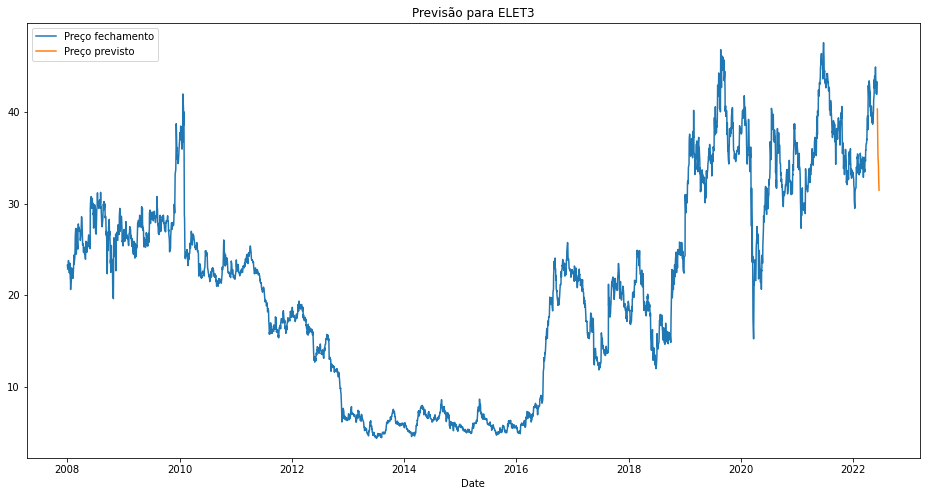

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Previsão para ELET3')
plt.plot(dados_ativo['Close'])
plt.plot(df_previsao['Fechamento'])
plt.legend(['Preço fechamento', 'Preço previsto'])
plt.xlabel('Date')

## **Vamos comparar com a realidade**

In [ ]:
dataInicial = "2022-06-06"
dataFinal = "2022-06-21"
dados_real = yf.download(codigoAcao, start = dataInicial, end = dataFinal)

[*********************100%***********************]  1 of 1 completed


Text(0.5, 0, 'Date')

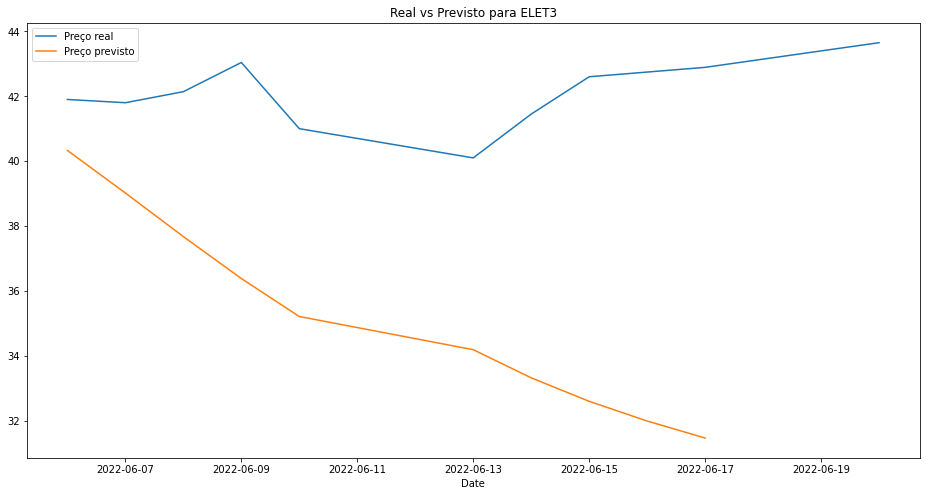

In [ ]:
plt.figure(figsize=(16,8))
plt.title('Real vs Previsto para ELET3')
plt.plot(dados_real['Close'])
plt.plot(df_previsao['Fechamento'])
plt.legend(['Preço real', 'Preço previsto'])
plt.xlabel('Date')

E aí, o que vocês acharam? Na minha opinião não deu muito certo!!

Usar apenas uma LSTM não foi suficiente para prever o preço de uma ação. Talves pudéssemos alterar os parâmetros do nosso modelo e chegar em resultado melhor,  talvez a criação de novas variáveis em nosso dataframe, ou outro ativo. 

Mas, o que de fato aconteceu nesse estudo foi a comprovação de que a previsão, conforme utilizada aqui, fica longe da realidade.



